# Learning undefined

Small exercise to learn the color of an image and having alpha 0 have no influence on learning to accelerate training and inference.

Import dependencies

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import IPython as ip

Load image to learn and preview.

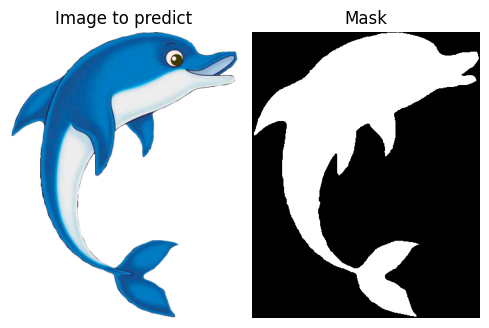

In [2]:
img_col = plt.imread("dolphin_color.png")
img_mask = torch.from_numpy(img_col[...,3] == 1).float()

fig, ax = plt.subplots(1,2,figsize=(5,10))
ax[0].imshow(img_col)
ax[0].set_title("Image to predict")
ax[1].imshow(img_mask, cmap="gray")
ax[1].set_title("Mask")
for a in ax: a.axis("off")
fig.tight_layout()
plt.show()

Helper functions

In [3]:
def generate_samples(img, mask, n_samples = 10):    
    # Create n samples from image 
    # Sample: X, Y coordinatem (Input to model) in image and R, G, B value (Label)

    # Generate n random image coordinates
    width, height = img.shape[1], img.shape[0]
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    coords = np.stack((y,x), axis=-1).reshape(width*height,2).astype(float)
    x = (np.random.random(n_samples) * coords.shape[0])
    x = coords[x.astype(int)]

    # Generate sample mask
    m = mask[x[...,0].astype(int), x[...,1].astype(int)]

    # Query n labels
    y = img[x[...,0].astype(int), x[...,1].astype(int), 0:3]
    x[...,0] /= height
    x[...,1] /= width

    return torch.from_numpy(x).float(), torch.from_numpy(y).float(), m.bool()

Model architecture

In [4]:
class ImageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.bound_stack = nn.Sequential(
        nn.Linear(2, 64), 
        nn.ReLU(),
        nn.Linear(64, 128), 
        nn.ReLU(),
        nn.Linear(128, 128), 
        nn.ReLU(),
        nn.Linear(128, 128), 
        nn.ReLU(),
        nn.Linear(128, 64), 
        nn.ReLU(),
        nn.Linear(64, 3)
    )
  def forward(self, x):
    return self.bound_stack(x)

Model training loop

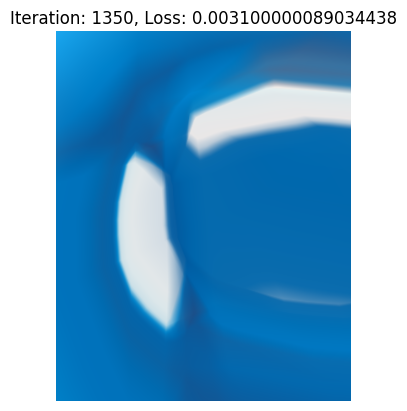

KeyboardInterrupt: 

In [5]:
# Training Hyperparameters
iterations, eval = 10000, 50
model = ImageModel()
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Training iterations of model
for i in range(iterations):

    # Generate training data / samples from image for this iteration
    features, targets, mask = generate_samples(img=img_col, mask=img_mask, n_samples=10000)
    
    # forward pass
    output = model.forward(features)

    # compute loss and zero loss if sample not in mask and UNDEFINED
    output[~mask] = targets[~mask]
    loss = criterion(output, targets)

    # zero gradients, backward pass, optimiser step
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if i % eval == 0:
        # Generate all image coordinates
        width, height = img_col.shape[1], img_col.shape[0]
        y, x = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
        coords = np.stack((y,x), axis=-1).reshape(width*height,2).astype(float)
        x = coords.copy()
        x[...,0] /= height
        x[...,1] /= width
        est_img = model.forward(torch.from_numpy(x).float())
        est_img = np.clip(est_img.reshape(height,width,3).detach().numpy(),0, 1)

        ip.display.clear_output(wait=True)
        plt.imshow(est_img)
        plt.title(f"Iteration: {i}, Loss: {np.round(loss.detach().numpy(), 4)}")
        plt.axis("off")
        plt.show()

Estimate full image

(-0.5, 347.5, 436.5, -0.5)

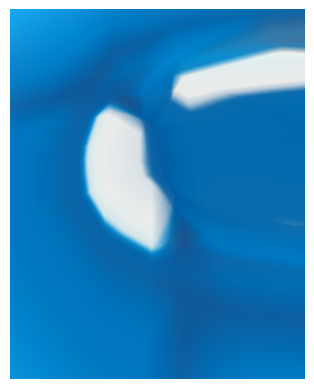

In [7]:
# Generate all image coordinates
width, height = img_col.shape[1], img_col.shape[0]
y, x = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
coords = np.stack((y,x), axis=-1).reshape(width*height,2).astype(float)
x = coords.copy()
x[...,0] /= width
x[...,1] /= height
est_img = model.forward(torch.from_numpy(x).float())
est_img = np.clip(est_img.reshape(height,width,3).detach().numpy(),0, 1)

plt.imshow(est_img)
plt.axis("off")

Try RGBA image plot

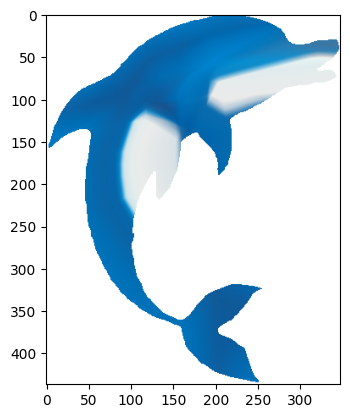

In [24]:
img_rgba = np.concatenate((est_img, img_mask.unsqueeze(dim=-1).numpy()), axis=-1)
plt.imshow(img_rgba)